In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set()

In [19]:
import unidecode

def normalizeSentence(sentence):
    
    temp = sentence.split(' ')
    new_sentence = []
    for word in temp:
        new_sentence.append(normalizeWord(word))
    new_sentence = ' '.join(new_sentence)
    
    return new_sentence

def normalizeWord(word):
    
    # lower case word
    word = word.lower()
    
    # remove accents
    word = unidecode.unidecode(word)
    
    return word

def joinSeparetedWord(word):
    
    # removing aspas
    word = word.split('\'')
    word = ''.join(word)
    
    # separete words from word
    word = word.split()
    
    # join separeted words by '-'
    word = '-'.join(word)
    
    return word

In [81]:
def selectByWord(word, sentences):
    # select subset of sentences that contains word
    # return indexs of sentences
    
    # normalize word
    normalized_word = normalizeWord(word)
    
    indexs = []
    
    for i, sentence in enumerate(sentences):
        # normalize sentence
        normalized_sentence = normalizeSentence(sentence)
        
        if normalized_word in normalized_sentence:
            #print(i, normalized_sentence)
            indexs.append(i)
    return indexs

In [21]:
def selectDfRowsByWord(data, word, column):
    '''
    Select specific rows that contains especific word in the column
    '''
    
    sentences = np.array(data[column].unique())

    # find sentences
    idxs = selectByWord(word, sentences)
    obj_sentences = sentences[idxs]

    servicos = pd.DataFrame()
    for sentence in obj_sentences:

        # select rows of exemplo
        temp = data[data[column] == sentence]

        # concatenate
        servicos = pd.concat([servicos, temp])
    try:
        temp = len(servicos[column].unique())
    except:
        print(word + ': Not found')
    
    return servicos.copy()

In [22]:
def valueFromUnique(date, unique, base, by = 'ds_elemento'):
    

    year = date[0]
    month = date[1]

    months = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
    aux = base[base['ano_exercicio'] == year]
    aux = aux[aux['mes_ref_extenso'] == months[int(month)-1]]
    aux = aux[aux[by] == unique]
    ans = aux['vl_despesa'].sum()
    
    del aux
    
    return ans

In [24]:
class Serie:
    '''
    
    Série temporal
    
    '''
    
    def __init__(self, name, years = [2018], word = 'serviço', column = 'ds_elemento', other_columns = None):
        
        if other_columns is not None:
            self.keep_columns_ = [column, 'vl_despesa', 'mes_ref_extenso', 'ano_exercicio']
            for col in other_columns:
                self.keep_columns_.append(col)
        else:
            self.keep_columns_ = [column, 'vl_despesa', 'mes_ref_extenso', 'ano_exercicio']
        
        self.years_ = years
        self.word_ = word
        self.name_ = name
        self.column_ = column
        self.df_ = pd.DataFrame()
        self.overview_ = {}
        self.serie_ = pd.DataFrame()
        self.population_ = None
        print('Reading data...')
        self.readData()
        print('Preparing data...')
        self.prepareData()
        print('\nBase for {} is ready!!'.format(self.name_))
        
    def readData(self):
        
        print('> reading population...')
        # reading population
        
        municipios_base = pd.read_csv('datasets/municipios.csv')
        municipios = municipios_base['Município'].values
        for i, municipio in enumerate(municipios):
            if normalizeWord(self.name_) == normalizeWord(municipio):
                self.population_ = municipios_base['Estimativa 2019'].values[i]
        if self.population_ is None:
            print('Erro: population not found')
            return
        
        print('> reading despesas...')
        # reading despesas
        
        for year in self.years_:
            print('>> year: '+str(year))
            temp = pd.read_csv('datasets/despesas/'+ str(year) +'/despesas-' + self.name_ + '-'+str(year)+'.csv', sep = ';',  encoding = "ISO-8859-1")
            temp.vl_despesa = temp.vl_despesa.apply(lambda x : float('.'.join(x.split(','))))
            temp = temp[self.keep_columns_]
            self.df_ = pd.concat([self.df_, temp]).reset_index(drop = True)
            
            # add percentual de despesa gasta sobre {column} e {word} sobre o valor total de despesa
            self.df_['%_despesa_ano'] = self.df_['vl_despesa'].apply(lambda x : 100*x/temp['vl_despesa'].values.sum())
        del temp
        
    def prepareData(self):
        
        self.df_ = selectDfRowsByWord(self.df_ , self.word_, self.column_).reset_index(drop = True)
        
        # normalizando nome dos meses
        self.df_['mes_ref_extenso'] = self.df_['mes_ref_extenso'].apply(lambda x : normalizeWord(x))
        
        print('> preparing overview...')
        # prepare overview by year and by unique of {column}
        for year in self.years_:
            despesas = []
            despesas_pctg = []
            base = self.df_[self.df_['ano_exercicio'] == year]
            uniques = list(base[self.column_].unique())
            for unique in uniques:
                temp = base[base[self.column_] == unique]['vl_despesa']
                despesas.append(temp.sum())
                temp = base[base[self.column_] == unique]['%_despesa_ano']
                despesas_pctg.append(temp.sum())
            
            temp = pd.DataFrame({self.column_: uniques})
            temp['vl_despesa'] = despesas
            temp['%_despesa_ano'] = despesas_pctg
            temp = temp.set_index(self.column_)
            
            self.overview_[year] = temp.copy()
        
        print('> preparing series...')
        # prepare series
        months = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
        
        # add dates:
        dates = []
        for year in self.years_:
            for i, month in enumerate(months):
                # number of month
                n = i+1
                if n >= 10:
                    n_str = str(n)
                else:
                    n_str = '0'+str(n)

                # index for month in year '{year}-{month}-{day}''
                date = str(year)+'-'+n_str
                dates.append(date)
        self.serie_['date'] = dates
        
        uniques = self.df_[self.column_].unique()
        for unique in uniques:
            values = []
            for year in self.years_:
                for i, month in enumerate(months):
                    date = [year, i+1]
                    values.append(valueFromUnique(date, unique, self.df_, self.column_))
            self.serie_[unique] = values 
        self.serie_ = self.serie_.set_index('date')
        
        del temp, base
                
        
    
    def plotPie(self, year, by = '%_despesa_ano', hue = 'ds_elemento', n = 10, ax = None):
    
        # select rows
        data = self.overview_[year]
        size_otheres = len(data) - n
        if size_otheres < 0:
            print('Erro: n > limite')
            return
        aux = data.sort_values(by = by)

        selected = aux.tail(n)
        others = aux.head(size_otheres)
        if len(others) != 0:
            temp = pd.DataFrame({hue: 'OUTROS',
                                 'vl_despesa': [others['vl_despesa'].sum()],
                                 '%_despesa_ano': [others['%_despesa_ano'].sum()]}).set_index(hue)

            todos = pd.concat([selected, temp], axis = 0)
        else:
            todos = selected
        todos = todos.sort_values(by = by)


        if ax is None:
            plt.figure(figsize = (15, 8))
            todos[by].plot(kind = 'pie', colormap = 'viridis')
        else:
            todos[by].plot(kind = 'pie', colormap = 'viridis', ax = ax)

        if len(others) != 0:
            del temp, aux
        else:
            del aux

In [80]:
test = Serie('cotia', years = np.arange(2015, 2019), word = 'reut', column = 'ds_acao')

Reading data...
> reading population...
> reading despesas...
>> year: 2015
>> year: 2016


/home/lucasnseq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



>> year: 2017
>> year: 2018
Preparing data...
reut: Not found


KeyError: 'mes_ref_extenso'

In [ ]:
test.df_['ds_despesa'].unique()

In [72]:
test.overview_[2018]['%_despesa_ano'].sum()

0.01072634505092962

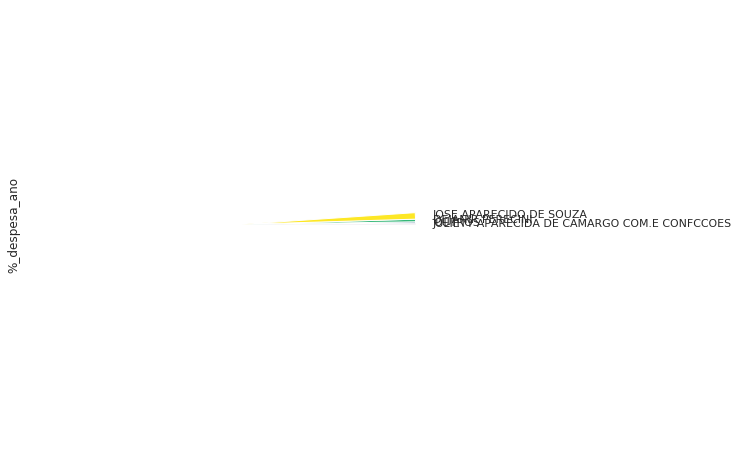

In [75]:
test.plotPie(year = 2018, n = 3)

In [41]:
test.serie_

,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESSOA JURÍDICA,31901137 - GRATIFICAÇÃO POR TEMPO DE SERVIÇO,33903943 - SERVIÇOS DE ENERGIA ELÉTRICA,33903944 - SERVIÇOS DE ÁGUA E ESGOTO,33903963 - SERVIÇOS GRÁFICOS E EDITORIAIS,33903990 - SERVIÇOS DE PUBLICIDADE LEGAL,33903958 - SERVIÇOS DE TELECOMUNICAÇÕES,"33903200 - MATERIAL, BEM OU SERVIÇO PARA DISTRIBUIÇÃO GRATUITA",33903699 - OUTROS SERVIÇOS DE PESSOA FÍSICA,33903962 - SERVIÇOS DE PRODUÇÃO INDUSTRIAL,...,33903948 - SERVIÇO DE SELEÇÃO E TREINAMENTO,33903967 - SERVIÇOS FUNERÁRIOS,44903900 - OUTROS SERVIÇOS DE TERCEIROS - PESSOA JURÍDICA,33903947 - SERVIÇOS DE COMUNICAÇÃO EM GERAL,"33903950 - SERVIÇO MÉDICO-HOSPITALAR, ODONTOLÓGICO E LABORATORIAIS","33903979 - SERVIÇO DE APOIO ADMINISTRATIVO, TÉCNICO E OPERACIONAL",33903957 - SERVIÇOS DE PROCESSAMENTO DE DADOS,"33903635 - SERVIÇO DE APOIO ADMINISTRATIVO, TÉCNICO E OPERACIONAL",33903983 - SERVIÇOS DE CÓPIAS E REPRODUÇÃO DE DOCUMENTOS,33903966 - SERVIÇOS JUDICIÁRIOS
date,,,,,,,,,,,,,,,,,,,,,
2017-01,1.006721e+08,20502234.66,2383529.59,2169288.94,15620.00,114631.09,486792.32,12690.00,181562.00,0.0,...,0.0,0.00,72416.63,33736.55,59485.38,0.00,541.83,0.00,0.0,0.0
2017-02,1.852635e+07,2691489.68,377126.39,1035683.05,0.00,11069.76,3492033.06,0.00,44716.20,0.0,...,0.0,0.00,0.00,4086.55,59421.94,6180190.32,287.82,0.00,0.0,0.0
2017-03,5.940203e+07,2879597.88,337338.53,681458.02,39888.00,8963.88,1206795.69,230084.00,24944.20,0.0,...,2694.0,0.00,0.00,246.62,0.00,9237489.48,0.00,0.00,0.0,0.0
2017-04,2.776081e+07,3186365.78,495905.77,330255.54,8354.00,11305.04,358442.20,8767.09,4814.20,0.0,...,0.0,0.00,0.00,44.65,54957.20,9221091.48,0.00,0.00,0.0,0.0
2017-05,4.471335e+07,3128220.66,965524.13,1510186.61,79821.00,97938.36,72743.73,624723.60,38490.72,0.0,...,0.0,0.00,0.00,44.65,0.00,14147394.32,978.55,0.00,0.0,0.0
2017-06,6.710970e+07,2885404.84,634147.33,1298424.33,169230.76,65407.28,941165.01,707237.77,27677.28,0.0,...,4428.0,0.00,0.00,0.00,0.00,9329887.48,0.00,0.00,0.0,0.0
2017-07,2.615819e+07,4351518.89,406510.17,673389.34,8640.00,100599.64,325088.31,2574841.26,66849.97,0.0,...,3360.0,0.00,0.00,0.00,7038.00,19723975.42,0.00,0.00,0.0,0.0
2017-08,3.407816e+07,4550914.48,2905546.48,452969.43,211681.40,63725.01,321270.30,516189.31,80193.63,0.0,...,0.0,0.00,30960.00,0.00,0.00,3148095.16,587.13,0.00,0.0,0.0
2017-09,3.488372e+07,3107890.35,1662094.85,554302.24,0.00,21315.40,1022141.37,2271427.18,36443.83,0.0,...,0.0,0.00,15480.00,0.00,0.00,9675481.48,0.00,0.00,0.0,0.0


In [85]:
print(test.serie_.shape)
test.serie_

(48, 28)


,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESSOA JURÍDICA,33903943 - SERVIÇOS DE ENERGIA ELÉTRICA,33903990 - SERVIÇOS DE PUBLICIDADE LEGAL,33903963 - SERVIÇOS GRÁFICOS E EDITORIAIS,33903947 - SERVIÇOS DE COMUNICAÇÃO EM GERAL,"33903950 - SERVIÇO MÉDICO-HOSPITALAR, ODONTOLÓGICO E LABORATORIAIS",33903944 - SERVIÇOS DE ÁGUA E ESGOTO,33903958 - SERVIÇOS DE TELECOMUNICAÇÕES,"33903200 - MATERIAL, BEM OU SERVIÇO PARA DISTRIBUIÇÃO GRATUITA",33903981 - SERVIÇOS BANCÁRIOS,...,"33903959 - SERVIÇOS DE ÁUDIO, VÍDEO E FOTO",33903606 - SERVIÇOS TÉCNICOS PROFISSIONAIS,33903965 - SERVIÇOS DE APOIO AO ENSINO,"33903979 - SERVIÇO DE APOIO ADMINISTRATIVO, TÉCNICO E OPERACIONAL","33903635 - SERVIÇO DE APOIO ADMINISTRATIVO, TÉCNICO E OPERACIONAL",33903951 - SERVIÇOS DE ANÁLISES E PESQUISAS CIENTÍFICAS,33903946 - SERVIÇOS DOMÉSTICOS,33903988 - SERVIÇOS DE PUBLICIDADE E PROPAGANDA,33903962 - SERVIÇOS DE PRODUÇÃO INDUSTRIAL,33903967 - SERVIÇOS FUNERÁRIOS
date,,,,,,,,,,,,,,,,,,,,,
2015-01,6.477948e+07,3257497.21,292889.43,0.00,346725.69,2240000.00,375660.55,1781598.17,1937489.84,1002906.20,...,18060.00,16890.00,0.0,22481152.12,940.00,0.00,0.0,0.0,0.0,0.00
2015-02,1.026754e+07,1162627.69,33582.28,0.00,46457.82,312564.04,62534.52,105599.73,284436.00,262286.94,...,12900.00,16890.00,0.0,3211593.16,0.00,0.00,0.0,0.0,0.0,0.00
2015-03,4.411449e+07,1007559.09,48118.38,0.00,50152.38,-308757.04,42551.47,424063.00,650946.64,268522.08,...,80040.00,16890.00,0.0,9634779.48,0.00,0.00,0.0,0.0,0.0,0.00
2015-04,2.242935e+07,1943968.50,105425.88,1791.00,1869377.54,286553.86,32904.27,263395.63,715505.96,780469.76,...,20700.00,17490.00,0.0,5761593.16,940.00,0.00,0.0,0.0,0.0,0.00
2015-05,3.161133e+07,1418518.17,25234.89,47642.40,985728.66,201882.15,85543.42,341709.88,2510003.73,286531.90,...,12900.00,16890.00,0.0,173546.04,940.00,0.00,0.0,0.0,0.0,0.00
2015-06,3.535340e+07,490990.36,82512.98,90083.40,598534.52,265589.38,102610.23,182690.73,2569928.63,292574.20,...,12900.00,16890.00,0.0,12844738.80,0.00,0.00,0.0,0.0,0.0,0.00
2015-07,3.237486e+07,1255273.68,63605.08,100216.80,527889.74,561277.84,95723.69,265157.85,3383326.10,328302.62,...,20700.00,16890.00,66.0,3373093.15,0.00,0.00,0.0,0.0,0.0,0.00
2015-08,2.459181e+07,628811.30,24582.58,71159.36,1647094.51,99269.90,41092.89,287090.22,2151295.99,172044.80,...,12900.00,16890.00,0.0,9046779.48,0.00,0.00,0.0,0.0,0.0,0.00
2015-09,3.650911e+07,2520712.60,56194.27,67617.04,304061.89,43559.37,117193.50,215416.29,927125.91,1558579.84,...,12900.00,16890.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00


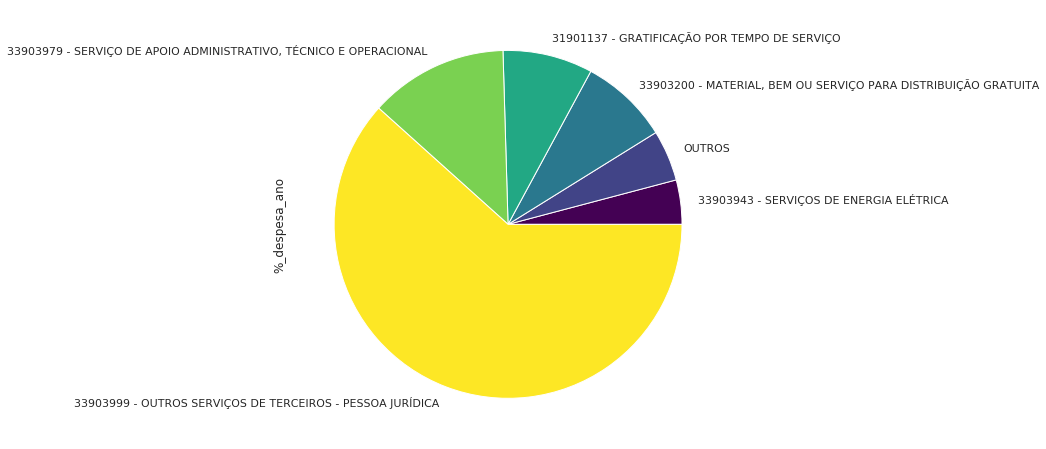

In [80]:
test.plotPie(year = 2018, n = 5)

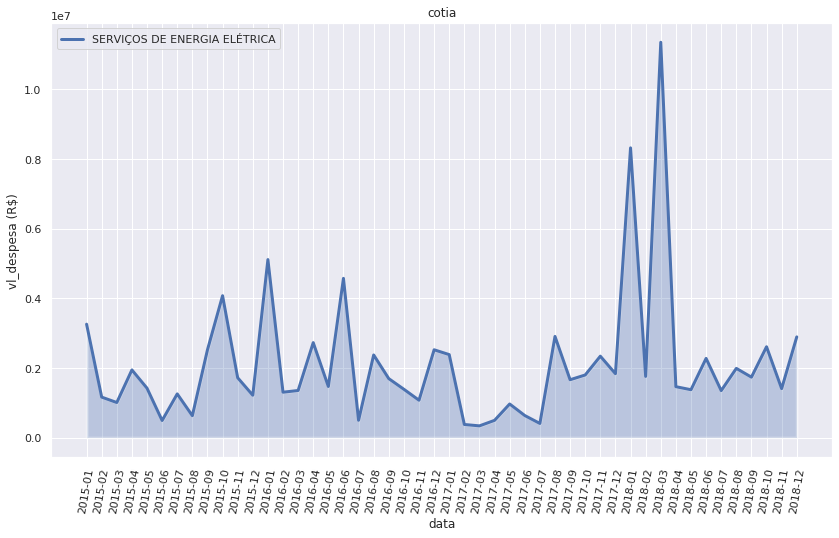

In [47]:
columns = ['33903943 - SERVIÇOS DE ENERGIA ELÉTRICA']

plt.figure(figsize=(14,8))
for column in columns:
    plt.plot(test.serie_[column], lw = 3, label = column.split(' - ')[1])
    aux = test.serie_[column].values.reshape(-1)
    x = np.arange(len(aux))
    plt.fill_between(x, y1 = np.zeros(len(aux)), y2 = aux, lw = 3, alpha = 0.3)
plt.xticks(rotation=80)
plt.title(test.name_)
plt.ylabel('vl_despesa (R$)')
plt.xlabel('data')
plt.legend()

In [29]:
test.df_

,%_despesa_ano,ano_exercicio,ds_elemento,mes_ref_extenso,vl_despesa
0,0.001654,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,novembro,5275.30
1,0.001663,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,dezembro,5304.89
2,0.000988,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,novembro,3149.81
3,0.000057,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,junho,180.77
4,0.000111,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,julho,353.86
5,0.000129,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,411.91
6,0.000129,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,411.91
7,0.000127,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,404.49
8,0.000127,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,404.49
9,0.000126,2017,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,401.19


In [48]:
test.df_

,%_despesa_ano,ano_exercicio,ds_elemento,mes_ref_extenso,vl_despesa
0,1.969740e-05,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,janeiro,570.00
1,1.503222e-04,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,fevereiro,4350.00
2,9.330345e-06,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,marco,270.00
3,9.330345e-06,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,270.00
4,6.897544e-07,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,19.96
5,3.222700e-02,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,932579.64
6,1.378818e-04,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,3990.00
7,2.764547e-05,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,800.00
8,1.590343e-02,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,maio,460210.73
9,1.503222e-04,2015,33903999 - OUTROS SERVIÇOS DE TERCEIROS - PESS...,junho,4350.00
